# Image Classification with Logistic Regression

First let us initialize Python.  To do so, run the below cell. If there is a warning, click "Run anyway". Our main task here has been to load the MedMNIST dataset and setup some relative packages.

In [1]:
!pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We would also set up the image format and make sure that we have all we need in this step.

In [2]:
print("hello world")
%matplotlib inline
import IPython.core.display
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn import *
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

hello world


The following code chunk ensures that the MedMNIST data has been properly set up. This would show the current version and the source of the MedMNIST dataset.




In [3]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/


# 1. Loading Data and Pre-processing
We aim the wrangle the data before we start our analysis with Logistic Regression.

In [4]:
data_flag = 'pathmnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

Running the following code chunk allows the data to be encapsulated into dataloader form. This code chunk may take a couple of minutes to run.



In [5]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz


We could take a quick look at the training and testing data we prepare for the analysis. We shall have 89996 datapoints for training and 7180 datapoints for testing.

In [6]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset PathMNIST (pathmnist)
    Number of datapoints: 89996
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into train

The following visualization gives us some idea on how we could expect the dataset to look like. The dataset consists of image patches of tissues and their respective label of category. We expect to categorize the tissues to the type that they should belong to.

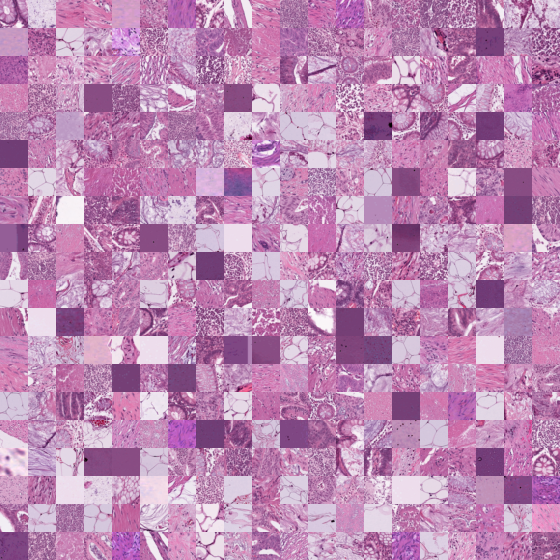

In [7]:
# visualization through .montage

train_dataset.montage(length=20)

We then create a dataset that consists only 2 different labels. First, we compare the tissue patches of adipose (body fat) and normal colon mucosa. Adipose tissue is labeled as '0' and normal colon mucosa is labeled as '6'. There should have been 17252 images in the training dataset and 2079 in the testing.


In [8]:
train_images_1 = train_dataset.imgs[[i for i, x in enumerate(np.logical_or(train_dataset.labels == 0, train_dataset.labels == 6)) if x]]
test_images_1 = test_dataset.imgs[[i for i, x in enumerate(np.logical_or(test_dataset.labels == 0, test_dataset.labels == 6)) if x]]

In [9]:
train_labels_1 = train_dataset.labels[[i for i, x in enumerate(np.logical_or(train_dataset.labels == 0, train_dataset.labels == 6)) if x]]
test_labels_1 = test_dataset.labels[[i for i, x in enumerate(np.logical_or(test_dataset.labels == 0, test_dataset.labels == 6)) if x]]

We also need to consider the labels to be categorical, as this will be much more reasonable than treating them as numbers. We give the label '0' for the adipose tissue and '1' for normal colon mucosa.

In [10]:
train_labels_1[train_labels_1 == 0] = int(0)
train_labels_1[train_labels_1 == 6] = int(1)
test_labels_1[test_labels_1 == 0] = int(0)
test_labels_1[test_labels_1 == 6] = int(1)

The data would now be arranged into the formality that we could handle with logistic regression. Before we establish our setup, we could check the following showcase to ensure that our data has been ready.



Label: [0]
The actual image:


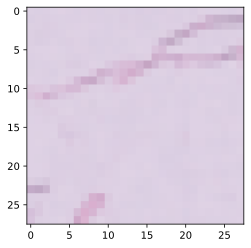

In [11]:
# Should be adipose tissue

plt.ion()
print('Label: ' + str(train_labels_1[0]))
print('The actual image:')
plt.imshow(train_images_1[0])
plt.show()

Label: [1]
The actual image:


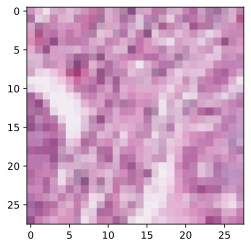

In [12]:
# Should be colon mucosa

plt.ion()
print('Label: ' + str(train_labels_1[100]))
print('The actual image:')
plt.imshow(train_images_1[100])
plt.show()

Similarly, we have got some samples from the testing dataset.

Label: [0]
The actual image:


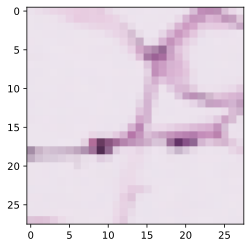

In [13]:
# Should be adipose tissue

plt.ion()
print('Label: ' + str(test_labels_1[0]))
print('The actual image:')
plt.imshow(test_images_1[0])
plt.show()

Label: [1]
The actual image:


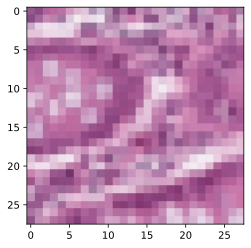

In [14]:
# Should be colon mucosa

plt.ion()
print('Label: ' + str(test_labels_1[100]))
print('The actual image:')
plt.imshow(test_images_1[100])
plt.show()

Heuristically, we could figure out the difference of the two types of tissue by ourselves based on our common sense in medicine. 

# 2. Let's use logistic regression to classify adipose vs. colon mucosa

Logistic regression is a supervised statistical model that uses idependent variables from each image to predict the dependent variable (whether the image represents adipose or colon mucosa). 

Before doing this, we may need to further wrangle the data. The data is 28 * 28 * 3 since it is a 2D RGB dataset. Our fitting is conducted through the *sklearn* package.

In [15]:
# Flatten the dataset
nsamples, nx, ny, nz = train_images_1.shape
train_images_1_reshaped = train_images_1.reshape((nsamples,nx*ny*nz))

In [16]:
# Flatten the dataset for the testing dataset
nsamples, nx, ny, nz = test_images_1.shape
test_images_1_reshaped = test_images_1.reshape((nsamples,nx*ny*nz))

We then establish our model. The regression may take some time to run, but it would figure out the results anyway. The execution time on my MacBook Pro has been about 15 minutes. Running the code on HPC could be faster, but colab is reasonably convenient anyway. 

In [17]:
# Choose the model 
# Since our sample size is large, we change the solver as the default one is incredibly slow
logreg = linear_model.LogisticRegression(solver = 'lbfgs', max_iter = 10000)

In [18]:
# Fit the model using our training set of data
fit_1 = logreg.fit(train_images_1_reshaped, train_labels_1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


After fitting the model, it's the time to predict the labels of new images from the testing dataset. Run the code below to see what the trained logistic regression model predicts is the identity of the first image in the training set.  

In [19]:
# predict a new image

logreg.predict(test_images_1[123].reshape(1, -1))

array([0], dtype=uint8)

Label: [0]
The actual image:


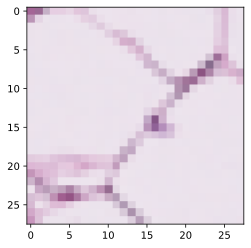

In [20]:
## Visualization to the image test_images_1[123] and see if it matches the logistic regression predicted label of the image. 

plt.ion()
print('Label: ' + str(test_labels_1[123]))
print('The actual image:')
plt.imshow(test_images_1[123])
plt.show()

Now, we will calculate the proportion of images which were correctly classified by the logistic regression model by comparing the predicted identity with the true labels (identities) of the numbers. 

In [21]:
# predict all the labels from the test set
pred_labels_1 = logreg.predict(test_images_1_reshaped)
# calculate accuracy
acc = metrics.accuracy_score(test_labels_1, pred_labels_1)
print("Testing accuracy =", acc)

Testing accuracy = 0.9374699374699375



Double click this text cell and hypothesize why you think the model was able to successfully or not successfully classify the images of adipose tissue and colon mucosa based on the calculated testing accuracy.

**Your answer:** The model is able to successfully classify the two categories of images with a testing accuracy of ~94%. The testing accuracy has been reasonably high. The reasona is that the difference of categories of the images could be shown through the features of the RGB data and extracted by the logistic regression model.






# 3. Now you try out using logistic regression to classify any two categories in the MedMNIST data

Here, you will be guided through training your own logistic regression model, and this time we could use it to differentiate any two categories in the dataset. You could try to differenciate the images of normal colon mucosa vs. colorectal adenocarcinoma epithelium (colon cancer tissue).

Double click this cell and type out your prediction for whether or not the prediction accuracy will be higher or lower than when the same model was used to differentiate between adipose and colon mucosa. 

**Your answer:** The prediction accuracy is expected to be lower, as normal colon mucosa would be much more similar to colon cancer tissue and we expect that there are less distinguishable features as compared to colon mucosa vs. adipose tissue.



    
    
    



We now create new datasets that contains the predictors and the outcomes by only selecting for images of normal colon mucosa vs. colorectal adenocarcinoma epithelium.

In [22]:
# select only images in the X and Y objects with two categories of your choice
train_images_2 = train_dataset.imgs[[i for i, x in enumerate(np.logical_or(train_dataset.labels == 8, train_dataset.labels == 6)) if x]]
test_images_2 = test_dataset.imgs[[i for i, x in enumerate(np.logical_or(test_dataset.labels == 8, test_dataset.labels == 6)) if x]]
train_labels_2 = train_dataset.labels[[i for i, x in enumerate(np.logical_or(train_dataset.labels == 8, train_dataset.labels == 6)) if x]]
test_labels_2 = test_dataset.labels[[i for i, x in enumerate(np.logical_or(test_dataset.labels == 8, test_dataset.labels == 6)) if x]]

The logistic regression model only accepts "0" or "1" as labels for the model. In this case, we need to manipulate the labels with the code we have provided earlier. Here we let "0" denote normal colon mucosa and "1" denote colorectal adenocarcinoma epithelium.

In [23]:
train_labels_2[train_labels_2 == 8] = int(1)
train_labels_2[train_labels_2 == 6] = int(0)
test_labels_2[test_labels_2 == 8] = int(1)
test_labels_2[test_labels_2 == 6] = int(0)

Now we could flat the dataset to make the data formality compatible with the required form of the *sklearn* package.

In [24]:
# image data flatting
nsamples, nx, ny, nz = train_images_2.shape
train_images_2_reshaped = train_images_2.reshape((nsamples,nx*ny*nz))

In [25]:
# Flatten the dataset for the testing dataset
nsamples, nx, ny, nz = test_images_2.shape
test_images_2_reshaped = test_images_2.reshape((nsamples,nx*ny*nz))

Select your logistic regression model as before: 

In [26]:
# Write your code to select regression model
# Since our sample size is large, we change the solver as the default one is incredibly slow
logreg = linear_model.LogisticRegression(solver = 'lbfgs', max_iter = 10000)

Use the selected model to fit the data using your training sets:

In [27]:
# Write your code here to fit the model using our training set
fit_2 = logreg.fit(train_images_2_reshaped, train_labels_2)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Predict the labels of new images from the test set.

In [28]:
# Write your code here to predict a new image
logreg.predict(test_images_2[0].reshape(1, -1))

array([1], dtype=uint8)

Label: [1]
The actual image:


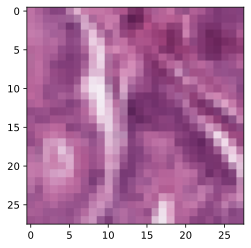

In [29]:
# Write your own code to show the image test_images_2[0] and see if it matches your labels
plt.ion()
print('Label: ' + str(test_labels_2[0]))
print('The actual image:')
plt.imshow(test_images_2[0])
plt.show()

Calculate the proportion of images which were correctly classified by the logistic regression model by comparing the predicted identity with the true labels (identities) of the numbers. 

In [30]:
# Write your code to predict all the labels from the test set, also calculate accuracy
# predict all the labels from the test set
pred_labels_2 = logreg.predict(test_images_2_reshaped)
# calculate accuracy
acc = metrics.accuracy_score(test_labels_2, pred_labels_2)
print("Testing accuracy =", acc)

Testing accuracy = 0.6534954407294833


This result of a significantly lowered testing accuracy could be expected, as we have mentioned earlier.

## 4.  Predict using the car images

Now, using the model that you have just trained, we will try to test out the logistic regression model on real images taken from the car camera. This exercise is similar to the one assigned to you last Friday. 

First upload your test dataset. Make sure your folder is named as "data_resized", then make sure it is a zip file called 'data_resized.zip' before uploading it to the left hand bar. To upload, click the folder icon on the left side and press the button with an up arrow. Then run the following codes to import your images. 

In [31]:
import zipfile
import fnmatch

imgdata = []
labels = []

# load the zip file
filename = 'data_resized.zip'
zfile = zipfile.ZipFile(filename, 'r')

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989/1000, 0.5870/1000, 0.1140/1000])


for name in zfile.namelist():
    # check file name matches
    if fnmatch.fnmatch(name, "*.jpg*"):
        #print("loading", name)
        # open file in memory, and parse as an image
        myfile = zfile.open(name)
        img = matplotlib.image.imread(myfile)
        myfile.close()

        img = rgb2gray(img)
        
        # append to data
        imgdata.append(img)
        labels.append(int(name[len("content/dataset_resized/trim_")] == '8'))  
        
zfile.close()
imgsize = img.shape
print("DONE: loaded {} images".format(len(imgdata)))

FileNotFoundError: ignored

Our labels are generated by the name of the uploaded dataset and they are in the number format, so we need to convert it into the string format. 

In [ ]:
print(labels)
# convert them into string
carlabels = list(map(str, labels))

In [ ]:
#print the dimension of the images contained in the object imgdata
imgdata[1].shape


### 4.1 Predict the labels of a car image

First, let us have a look at one of the images. 



In [ ]:
# choose a new image from your imgdata 
new_img = imgdata[2]

plt.imshow(new_img, cmap=plt.cm.gray, interpolation='nearest')
plt.show()

In [ ]:
# convert your data into a vector
# then insert it into the predict function to predict the label for this new image
logreg.predict(new_img.reshape(1, -1))

### 4.2 Prediction performance using all the car images

In [ ]:
# first we need to convert the uploaded dataset into a big matrix with each image as a vector in each row
# we also need to convert the label which is in the list format to the array format 
# these adjustments are for the correct input format to the predict function 

carimages = np.empty((21, np.prod(imgdata[0].shape))) # create empty array
for i,img in enumerate(imgdata):
    carimages[i,:] = np.ravel(img)           # for each image, turn it into a vector
labels = np.asarray(labels)  # convert list to numpy array
print(carimages.shape)
print(labels.shape)

What do you notice about the dimensions of the carimages object? Why are the dimensions important here? 

**Your Answer**: The model requires a correct formality to run, and the data wrangling is necessary. Otherwise, directly dumping the data into the model may cause errors.




In [ ]:
predY = logreg.predict(carimages)
acc = metrics.accuracy_score(carlabels, predY)
print("Testing accuracy =", acc)

# 4. Analyzing the classifier

> Indented block


Run the below code to show the hyperplane parameter $\mathbf{w}$ as an image.  

In [ ]:
# logreg is the learned logistic regression model
wimg = logreg.coef_.reshape(28,28)      # get the w and reshape into an image
mycmap = matplotlib.colors.LinearSegmentedColormap.from_list('mycmap', ["#0000FF", "#FFFFFF", "#FF0000"])
mm = max(wimg.max(), -wimg.min())
plt.imshow(wimg, interpolation='nearest', cmap=mycmap, vmin=-mm, vmax=mm)
plt.colorbar()
plt.title("weight image")
plt.show()

Recall that the classifier prediction is based on the sign of the function $f(\mathbf{x}) = \mathbf{w}^T\mathbf{x}+b = \sum_{i=1}^P w_ix_i + b$.  Here each $x_i$ is a pixel in the image, and $w_i$ is the corresponding weight.  Hence, the function is multiplying image by the weight of image, and then summing over all pixels.

In order for $f(\mathbf{x})$ to be positive, then the positive values of the weight image (red regions) should match the positive values in the digit image (white pixels), and the negative values of the weight image (blue regions) should be matched with negative values in the digit image (black pixels).

Hence, we can have the following interpretation:
<table>
<tr><th>Class</th><th>red regions (positive weights)</th><th>blue regions (negative weights)</th><th>white regions (weights near 0)</th></tr>
<tr><td> 1 </td><td>white pixels in digit image</td><td>black pixels in digit image</td><td> region not important </td></tr>
<tr><td> 0 </td><td>black pixels in digit image</td><td>white pixels in digit image</td><td> region not important </td></tr>
</table>
  
__Question: Looking at the weight image, what parts of the digit is the classifier looking at to determine the digit? Does this make sense to you?__

**Your answer:**

Now let's look at the misclassified faces in the test set.  Run the below code to show the misclassifed and correctly classified faces.

In [ ]:
# predYtest are the class predictions on the test set.

# find misclassified test images
predYtest = logreg.predict(testX)
inds = np.where(predYtest != testY) # get indices of misclassified test images

# randomly pick 5 to present
sub_inds = random.sample(inds[0].tolist(), 5)

plt.figure(figsize = (10, 3))

plt.figure(figsize=(10, 3))
for index, (image, label) in enumerate(zip(testX[sub_inds], testY[sub_inds])):
    predlabel = predYtest[sub_inds[index]]
    plt.subplot(1, 5, index + 1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.title(("Original:'%s'\n Prediction:'%s'") % (label, predlabel), fontsize = 10)

_Why did the classifier make incorrect predictions on the misclassified digits?_

**Your Answer:**